In [8]:
import pandas as pd
pd.options.display.max_columns=200
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

In [9]:
data = pd.read_csv('data/btc_data.csv', index_col=0)

In [10]:
# Sélectionner les caractéristiques et exclure la dernière ligne
features = data.drop(columns=['progression tomorrow', 'target', 'close', 'high', 'low', 'volumefrom', 'market_cap', 'difficulty']).iloc[:-1, :]
target = data['target'].iloc[:-1]

In [11]:
# Définir la taille de la fenêtre initiale
window_size = 1000

In [12]:
def train_model(data, model, features, target, window_size):
      
      # Initialiser les listes pour stocker les prédictions et les vraies valeurs
      predictions = []
      actuals = []

      # Boucle à travers les données de la taille de la fenêtre jusqu'à la fin des données
      for i in range(window_size, len(data) - 1):
            # Diviser les données en ensembles d'entraînement et de test
            X_train = features.iloc[i-window_size:i, :]
            y_train = target.iloc[i-window_size:i]
            X_test = features.iloc[i:i+1, :]
            y_test = target.iloc[i]

            #Normaliser les données
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            
            # Entraîner un modèle
            model.fit(X_train, y_train)
            
            # Faire une prédiction
            prediction = model.predict(X_test)[0]
            
            # Stocker les prédictions et les vraies valeurs
            predictions.append(prediction)
            actuals.append(y_test)

      # Évaluer le modèle
      accuracy = accuracy_score(actuals, predictions)
      print(f'Model Accuracy: {accuracy * 100:.2f}%')

In [13]:
from sklearn.dummy import DummyClassifier

dummy_model = DummyClassifier(strategy="most_frequent")
train_model(data, dummy_model, features, target, window_size)

Model Accuracy: 52.23%


In [14]:
def plot_feature_importance(model, feature_names):
    # Récupérer les coefficients du modèle
    coefficients = model.coef_[0]
    
    # Créer un DataFrame pour stocker les caractéristiques et leurs importances
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': coefficients
    })
    
    # Trier le DataFrame en fonction de l'importance
    feature_importance = feature_importance.sort_values(by='Importance', key=abs, ascending=False)
    
    # Visualiser l'importance des caractéristiques
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.title('Feature Importance for Logistic Regression')
    plt.gca().invert_yaxis()  # Pour afficher la caractéristique la plus importante en haut
    plt.show()

In [15]:
def earn_metric(predicted_probs, progressions, n_days, i):
      base = c = 1
      for j in range(n_days):
            index = len(predicted_probs) - n_days + j
            c *= predicted_probs[index] * progressions[index] + (1 - predicted_probs[index])
            base *= progressions[index]
      return c / base


In [16]:
def earn_metric(predicted_probs, progressions, n_days, i):
      base = c = 1
      for j in range(n_days):
            index = len(predicted_probs) - n_days + j
            c *= predicted_probs[index] * progressions[index] + (1 - predicted_probs[index])
            base *= progressions[index]
      return c / base


def train_model_proba_metric(data, model, features, target, window_size, n_days):
      
    # Initialiser les listes pour stocker les probabilités prédites et les vraies valeurs
    predicted_probs = []
    progressions = []
    metric = []

    # Boucle à travers les données de la taille de la fenêtre jusqu'à la fin des données
    for i in range(window_size, len(data) - 1):
        # Diviser les données en ensembles d'entraînement et de test
        X_train = features.iloc[i-window_size:i, :]
        y_train = target.iloc[i-window_size:i]
        X_test = features.iloc[i:i+1, :]
        y_test = target.iloc[i]

        # Normaliser les données
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Entraîner un modèle
        model.fit(X_train, y_train)
        
        # Obtenir les probabilités prédites pour la classe positive (par exemple, 1)
        prediction_prob = model.predict_proba(X_test)[:, 1]
        
        # Stocker les probabilités prédites et les vraies valeurs
        predicted_probs.extend(prediction_prob)
        
        # Récupérer la progression réelle
        progressions.append(data.iloc[i]['progression tomorrow']+1)

        if i >= window_size + n_days:
            metric.append(earn_metric(predicted_probs, progressions, n_days, i))
    
    return metric 

In [89]:
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression()
n_days = 31
earnings = train_model_proba_metric(data, logistic_regression, features, target, window_size, n_days)

In [90]:
np.mean(earnings)

1.0443524998161493

In [43]:
model = LogisticRegression()
# Initialiser les listes pour stocker les probabilités prédites et les vraies valeurs
predicted_probs = []
actuals = []
progressions = []

c = 1
base = 1

for i in range(31):
      # Diviser les données en ensembles d'entraînement et de test
      X_train = features.iloc[i:window_size+i, :]
      y_train = target.iloc[i:window_size+i]
      X_test = features.iloc[window_size+i : window_size+i+1, :]
      y_test = target.iloc[window_size+i]

      # Normaliser les données
      scaler = StandardScaler()
      X_train_scaled = scaler.fit_transform(X_train)
      X_test_scaled = scaler.transform(X_test)

      # Entraîner un modèle
      model.fit(X_train_scaled, y_train)

      # Obtenir les probabilités prédites pour la classe positive (par exemple, 1)
      prediction_prob = model.predict_proba(X_test_scaled)[:, 1]

      # Stocker les probabilités prédites et les vraies valeurs
      predicted_probs.extend(prediction_prob)
      actuals.append(y_test)
      progressions.append(data.iloc[window_size+i]['progression tomorrow']+1)

      c *= predicted_probs[i] * progressions[i] + (1 - predicted_probs[i])
      base *= progressions[i]


      print(f'round {i}')
      print(f'progres {y_test}')
      print(f'c : {c}')
      print(f'base : {base}')
      print('--------'*5)

round 0
progres 1
c : 1.0080141881530016
base : 1.013347921225383
----------------------------------------
round 1
progres 1
c : 1.020445935000118
base : 1.0393873085339171
----------------------------------------
round 2
progres 1
c : 1.0258641097949759
base : 1.0494529540481403
----------------------------------------
round 3
progres 0
c : 1.0194220140560268
base : 1.0350109409190378
----------------------------------------
round 4
progres 0
c : 1.0143388633742798
base : 1.0233406272793588
----------------------------------------
round 5
progres 0
c : 0.9625493866913664
base : 0.8971553610503288
----------------------------------------
round 6
progres 1
c : 0.9898226805290491
base : 0.9554339897884762
----------------------------------------
round 7
progres 1
c : 1.0089689614768238
base : 0.9979576951130567
----------------------------------------
round 8
progres 0
c : 1.0086249159379632
base : 0.9970824215900808
----------------------------------------
round 9
progres 1
c : 1.011657

In [18]:
progressions

[1.013347921225383,
 1.0256963938674153,
 1.0096842105263157,
 0.9862385321100919,
 0.988724453840733,
 0.8766928011404134,
 1.064959349593496,
 1.044507214291167,
 0.9991229352433855,
 1.0080468178493052,
 0.9854862119013063,
 1.005081001472754,
 1.0220528976481793,
 1.0065232974910394,
 0.9977921800441564,
 1.0199143468950749,
 1.032472531317797,
 1.0260286043516573,
 1.0443945299597013,
 0.9666645581630717,
 1.0312131919905771,
 1.0678342534424774,
 1.0883646303779415,
 1.016107016107016,
 1.0358946802794198,
 1.0529619255109453,
 1.1230602492733632,
 0.9079264815545905,
 0.956034399458885,
 0.9529007479280373,
 1.0973165040305473]

In [19]:
predicted_probs

[0.60040721080683,
 0.479947056414951,
 0.548275436829798,
 0.4563232295849949,
 0.4422230635316302,
 0.4140664330528999,
 0.4361871849836109,
 0.43460689675727876,
 0.3887822819149118,
 0.37363990309366896,
 0.387200441772941,
 0.4055367094480023,
 0.4258094386710644,
 0.39559626208842863,
 0.37528370294677327,
 0.3506205662074579,
 0.2927787947594506,
 0.3714842412223311,
 0.4105885437975299,
 0.5173820022615735,
 0.6836440433816976,
 0.704059632038982,
 0.7912445607844866,
 0.6580611503646457,
 0.6503088615065241,
 0.6730367978693366,
 0.7328463246790808,
 0.591138581770577,
 0.5713847961102692,
 0.5889210519426863,
 0.5655505962196752]

In [20]:
c=100

In [21]:
c *= (progressions[0]*predicted_probs[0] + 1 - predicted_probs[0])

In [22]:
c

100.80141881530018

In [23]:
c *= (progressions[1]*predicted_probs[1] + 1 - predicted_probs[1])

In [24]:
progressions[6]

1.064959349593496

In [25]:
c = 100

In [26]:
c *= predicted_probs[5] * progressions[5] + (1 - predicted_probs[5])

In [27]:
c

94.89426279984663

In [56]:
# Définir la grille de paramètres
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [50, 100, 200, 500],
    'fit_intercept': [True, False],
    'class_weight': [None, 'balanced'],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

In [57]:
total_combinations = (
    len(param_grid['penalty']) *
    len(param_grid['C']) *
    len(param_grid['solver']) *
    len(param_grid['max_iter']) *
    len(param_grid['fit_intercept']) *
    len(param_grid['class_weight']) *
    len(param_grid['l1_ratio'])
)

incompatible_l1 = 3 * len(param_grid['C']) * len(param_grid['max_iter']) * len(param_grid['fit_intercept']) * len(param_grid['class_weight']) * len(param_grid['l1_ratio'])
incompatible_elasticnet = 4 * len(param_grid['C']) * len(param_grid['max_iter']) * len(param_grid['fit_intercept']) * len(param_grid['class_weight']) * len(param_grid['l1_ratio'])
incompatible_none = len(param_grid['C']) * len(param_grid['max_iter']) * len(param_grid['fit_intercept']) * len(param_grid['class_weight']) * len(param_grid['l1_ratio'])
incompatible_none = len(param_grid['C']) * len(param_grid['max_iter']) * len(param_grid['fit_intercept']) * len(param_grid['class_weight']) * len(param_grid['l1_ratio'])
incompatible_l1_ratio = 3 * len(param_grid['C']) * len(param_grid['solver']) * len(param_grid['max_iter']) * len(param_grid['fit_intercept']) * len(param_grid['class_weight'])
total_incompatibilities = incompatible_l1 + incompatible_elasticnet + incompatible_none + incompatible_l1_ratio

In [58]:
total_combinations

9600

In [59]:
total_incompatibilities

5280

In [60]:
total_combinations - total_incompatibilities

4320

In [62]:
def train_model_grid(data, model, features, target, window_size):
      
      # Initialiser les listes pour stocker les prédictions et les vraies valeurs
      predictions = []
      actuals = []

      # Boucle à travers les données de la taille de la fenêtre jusqu'à la fin des données
      for i in range(window_size, len(data) - 1):
            # Diviser les données en ensembles d'entraînement et de test
            X_train = features.iloc[i-window_size:i, :]
            y_train = target.iloc[i-window_size:i]
            X_test = features.iloc[i:i+1, :]
            y_test = target.iloc[i]

            #Normaliser les données
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            
            # Entraîner un modèle
            model.fit(X_train, y_train)
            
            # Faire une prédiction
            prediction = model.predict(X_test)[0]
            
            # Stocker les prédictions et les vraies valeurs
            predictions.append(prediction)
            actuals.append(y_test)

      # Évaluer le modèle
      accuracy = accuracy_score(actuals, predictions)
      return accuracy

In [17]:
data_crop = data.dropna()

In [18]:
data_crop

,high,low,open,volumefrom,volumeto,close,market_cap,progression daily,progression tomorrow,target,ema_26,ema_12,macd,rsi,relative_volume,obv,atr,bollinger_upper,bollinger_lower,k,momentum,difficulty
2013-04-28,136.68,127.50,128.00,27503.11,3.662548e+06,134.44,1.500518e+09,-0.065011,0.050312,1,120.221309,129.173650,8.952341,61.476915,0.191747,1.556268e+08,29.514286,202.798775,52.879225,66.990208,34.93,8.974296e+06
2013-04-29,149.08,133.00,134.44,70186.33,9.983975e+06,144.00,1.575032e+09,0.050312,0.071110,1,121.274545,129.983857,8.709312,64.250898,0.544309,1.656108e+08,28.842143,194.821846,55.550154,72.521903,25.37,8.974296e+06
2013-04-30,146.93,134.00,144.00,65198.58,9.119201e+06,139.23,1.501657e+09,0.071110,-0.033125,0,122.957912,132.140187,9.182275,69.512890,0.558648,1.747300e+08,26.909286,171.214729,70.557271,78.250751,25.50,8.974296e+06
2013-05-01,140.06,104.00,139.23,179988.85,2.178794e+07,116.38,1.298952e+09,-0.033125,-0.164117,0,124.163252,133.230927,9.067675,73.844290,1.371631,1.529420e+08,27.232143,166.364363,72.830637,66.181773,12.13,1.007629e+07
2013-05-02,126.90,91.11,116.38,234129.17,2.493210e+07,106.25,1.148668e+09,-0.164117,-0.087042,0,123.586715,130.638477,7.051762,57.942078,1.514463,1.280099e+08,27.480714,165.890185,72.452815,33.550186,-2.82,1.007629e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-13,27110.91,26674.97,26756.23,18507.04,4.967794e+08,26862.90,5.216077e+11,-0.004279,0.003987,1,27129.215560,27294.402418,165.186858,46.835697,0.904417,1.270529e+10,785.304286,28397.807436,25925.062564,10.940893,-750.99,5.732151e+13
2023-10-14,26982.78,26810.02,26862.90,5865.21,1.576854e+08,26854.52,5.236556e+11,0.003987,-0.000312,0,27109.488482,27228.017431,118.528949,49.455572,0.288510,1.286298e+10,786.607857,28390.511290,25960.107710,16.135237,-565.76,5.732151e+13
2023-10-15,27297.26,26813.06,26854.52,10978.68,2.971100e+08,27177.41,5.239792e+11,-0.000312,0.012024,1,27090.601927,27170.556287,79.954360,48.700891,0.555745,1.256587e+10,738.972857,28353.377450,26056.549550,15.727169,-935.28,5.732151e+13
2023-10-16,30009.15,27131.48,27177.41,66720.48,1.884463e+09,28518.37,5.296435e+11,0.012024,0.049341,1,27097.032155,27171.610705,74.578550,38.382575,3.228924,1.445033e+10,848.527857,28315.553845,26182.321155,18.572004,-237.18,5.732151e+13


In [19]:
# Sélectionner les caractéristiques et exclure la dernière ligne
features = data.drop(columns=['progression tomorrow', 'target', 'close', 'high', 'low', 'volumefrom']).iloc[:-1, :]
target = data['target'].iloc[:-1]

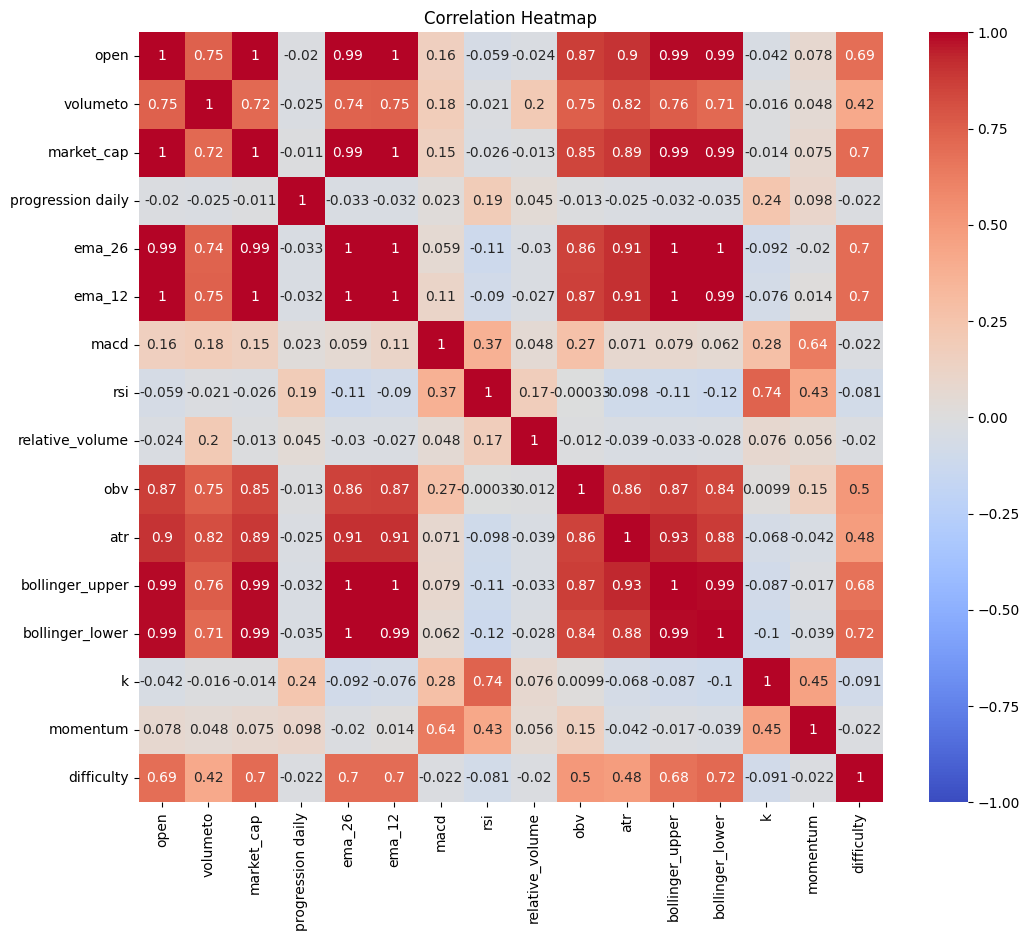

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculer la matrice de corrélation
corr_matrix = features.corr()

# Afficher la heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()